In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
from matplotlib.ticker import MaxNLocator


plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

## Step 1: Get the scale

In [2]:
# this functions fits a sine to the discharge data and extacts the response around the drive frequency

ll = likelihood_analyser.LikelihoodAnalyser()
def get_scale(i,phase="sin",fsamp=5000,drive_freq=71,decimate=10,bandwidth=2):
    calibrationFile = step_cal_files[i]       
    calibFreqs = np.fft.rfftfreq(len(calibrationFile.electrode_data[0]), d=1./5000)
    fft_angles = np.angle(np.fft.rfft(calibrationFile.electrode_data[0]))
    if(phase=="cos"):
        phaseResponse = (fft_angles[calibFreqs==drive_freq])%(2*np.pi)
    elif(phase=="sin"):
        phaseResponse = (fft_angles[calibFreqs==drive_freq]+np.pi/2)%(2*np.pi)

    print(phaseResponse,np.std(calibrationFile.electrode_data[0])*np.sqrt(2),np.std(calibrationFile.electrode_data[1])*np.sqrt(2))

    fit_kwargs = {'A': 0, 'f': drive_freq, 'phi': phaseResponse, 
                  'error_A': 1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
                  'limit_phi': [-2 * np.pi, 2 * np.pi], 
                  'limit_A': [-1, 1], 
                  'print_level': 0, 'fix_f': True, 'fix_phi': True}

    frequency = fit_kwargs['f']

    b, a = signal.butter(3, [2.*(drive_freq-bandwidth/2.)/fsamp, 2.*(drive_freq+bandwidth/2.)/fsamp ], btype = 'bandpass')
    xx2 = signal.filtfilt(b, a, calibrationFile.x2)[::decimate]
    
    m1_tmp = ll.find_mle_sin(xx2, fsamp=5000/decimate, noise_rms=1, plot=False, suppress_print=True, **fit_kwargs)
    
    return m1_tmp.values[0]

In [3]:
# load discharge data for the respective bead

step_cal_dir = r'/data/new_trap/20210823/Bead2/Discharge/FineDischarge/'
step_cal_files = load_dir(step_cal_dir, start_file=0)

100%|██████████| 160/160 [00:01<00:00, 149.00it/s]

160  files in folder
160  files loaded


In [4]:
# fill a list with response values for every file in the discharge folder

dischargeAmps = []
for i in range(len(step_cal_files)):
    print(i,'/',len(step_cal_files))
    dischargeAmps.append(get_scale(i))

0 / 160
[0.08151223] 9.996290065173422 9.996317023763515
1 / 160
[0.08148986] 9.996285397435814 9.996313719839598
2 / 160
[0.08151027] 9.996288748977454 9.99631377685892
3 / 160
[0.08150766] 9.996289001018235 9.996311207240812
4 / 160
[0.08152151] 9.996280739455745 9.996308257021823
5 / 160
[0.08151656] 9.99628407703431 9.996309944653982
6 / 160
[0.08153246] 9.996281536933344 9.996308276937292
7 / 160
[0.08153834] 9.996284976067841 9.996310245096714
8 / 160
[0.08154216] 9.996286247366939 9.996309219321223
9 / 160
[0.08153307] 9.996281780087484 9.99630774334229
10 / 160
[0.08154175] 9.996282855429635 9.996309751903178
11 / 160
[0.08154778] 9.996283481551496 9.9963076805986
12 / 160
[0.08154013] 9.996282418801183 9.996308561178529
13 / 160
[0.08153213] 9.996286664988475 9.996306464514326
14 / 160
[0.08153279] 9.996288037570196 9.996306604111847
15 / 160
[0.08153718] 9.99629050304092 9.996310208418985
16 / 160
[0.08153773] 9.99629189643563 9.996309829634573
17 / 160
[0.08153177] 9.9962848

149 / 160
[0.08153172] 9.996289370541222 9.996307899702357
150 / 160
[0.08152797] 9.996283176744285 9.996305164095807
151 / 160
[0.08152914] 9.996285002860057 9.99630428327062
152 / 160
[0.08153586] 9.99628791383331 9.996306522868508
153 / 160
[0.08152052] 9.996288159636872 9.996305700079171
154 / 160
[0.08152625] 9.996286647416502 9.996305328597298
155 / 160
[0.08152876] 9.996280108323218 9.99630255763704
156 / 160
[0.08151195] 9.996284489814508 9.996303218665163
157 / 160
[0.08151405] 9.996285882345111 9.996303882086954
158 / 160
[0.0815276] 9.996281903463922 9.996306215067142
159 / 160
[0.0815218] 9.996283860738322 9.9963047141371


In [64]:
# extract the applied voltage the

dischargeVoltage = np.std(step_cal_files[-1].electrode_data[0])*np.sqrt(2)+np.std(step_cal_files[-1].electrode_data[1])*np.sqrt(2) 

# select (manually) the charge and the respective files
charge=1 
scaleX = np.abs(np.mean(dischargeAmps[145:154]))/charge # scales bits to charges
eta=0.6 # get from COMSOL 
scaleForceX= np.abs(np.mean(dischargeAmps[145:154]))/(dischargeVoltage*1.602e-19*eta)*8e-3 #scales bits to Newton : Is there a time missing?

#scaleY = scaleX*-1.0502 # from discharge values in x and y
#print("Scale is ", scaleY)

print("voltage: ", dischargeVoltage) 
print(scaleX)
print(scaleX/scaleForceX)

voltage:  19.99258857487542
1.9197005106404614e-05
2.4021095172712816e-16


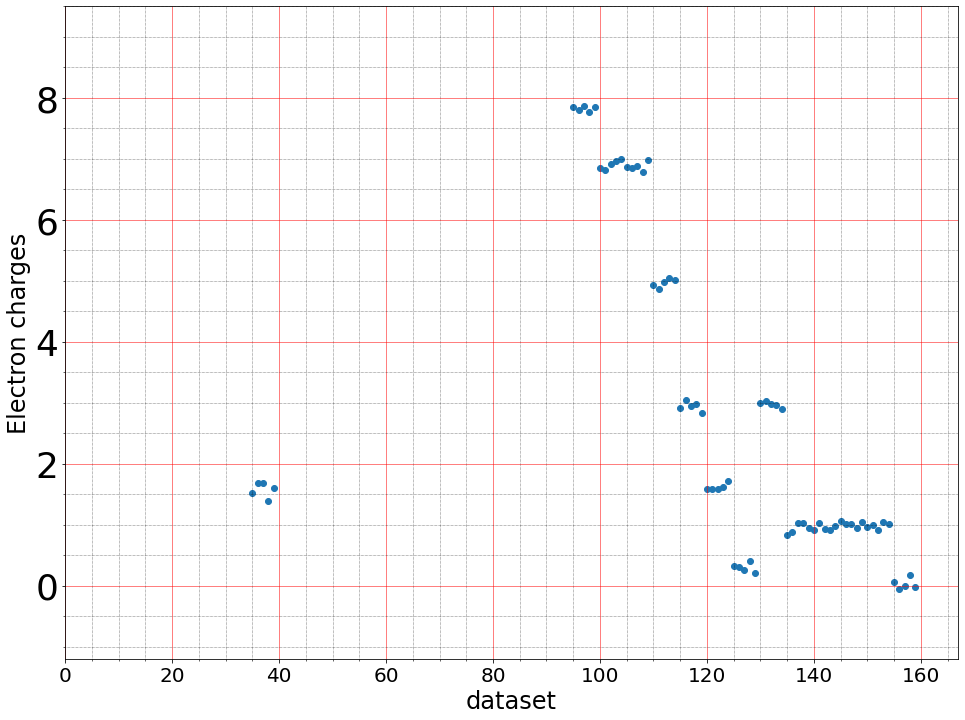

In [65]:
# evaluate your discharge data calbiration in terms of charges

dischargeAmpArr = np.array(dischargeAmps)
_,ax = plt.subplots(figsize=(16,12))

ax.scatter(range(len(dischargeAmpArr)), -1*dischargeAmpArr/(scaleX), label='fit phase')

ax.set(xlabel='dataset', ylabel='Electron charges',ylim=(-1.2,9.5), xlim=(0,None))
ax.grid(axis='y')
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))


## Step 2 define the functions to get the millicharge response

In [66]:
# extract the response
# this is the same file as the get_scale but with a few more inputs
def get_response(index,folder,drive_freq=71,axis="x",phaseCalib1 = -0.0563):
    '''
    index:file
    folder:folder
    drive_freq: frequency you want to analyze, usually f and 2f of your drive
    axis: "x","y" or "z"
    phaseCalib: Offset of phase calibration as extracted from discharge, single electrode or TREK data
    '''
    
    ll = likelihood_analyser.LikelihoodAnalyser()
    bandwidth = 2
    decimate = 10
    fsamp =5000
    drive_freq1=drive_freq
    fname = folder + 'Discharge_'+str(index)+'.h5'
    if(index==1):print(fname)
    neutralityFile = BDF.BeadDataFile(fname=fname)
    fit_kwargs = {'A': 0, 'f': drive_freq1, 'phi': phaseCalib1, 
                  'error_A': 1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
                  'limit_phi': [-2 * np.pi, 2 * np.pi], 
                  'limit_A': [-1, 1], 
                  'print_level': 0, 'fix_f': True, 'fix_phi': True}
    
    if(axis=="x"):
        inSignal=neutralityFile.x2
    if(axis=="y"):
        inSignal=neutralityFile.y2
    if(axis=="z"):
        inSignal=neutralityFile.z2
    
    b, a = signal.butter(3, [2.*(drive_freq1-bandwidth/2.)/fsamp, 2.*(drive_freq1+bandwidth/2.)/fsamp ], btype = 'bandpass')
    xx2 = signal.filtfilt(b, a, inSignal)[::decimate]
    
    m1_tmp = ll.find_mle_sin(xx2, fsamp=5000/decimate, noise_rms=1, plot=False, suppress_print=True, **fit_kwargs)
    
    return m1_tmp.values[0]


In [67]:
### extract voltage from the files on both electrodes
def get_voltage(index,folder):
    trekConvFactor = 200 
    fname = folder + 'Discharge_'+ str(index)+'.h5'
    neutralityFile = BDF.BeadDataFile(fname=fname)
    voltage0= np.std(neutralityFile.electrode_data[0])*np.sqrt(2)*trekConvFactor
    voltage1= np.std(neutralityFile.electrode_data[1])*np.sqrt(2)*trekConvFactor
    return voltage0,voltage1


In [68]:
# wrapper to extract the total voltage applied, 
# the voltage at each electrode and the response at the drive frequency and its 2nd harmonic
def get_response_total(index,folder,drive_freq=71,axis="x",phaseCalib1 = -0.0563):
    voltage0,voltage1= get_voltage(index,folder)
    firstVal = get_response(index,folder,drive_freq,axis,phaseCalib1)
    secondVal = get_response(index,folder,2*drive_freq,axis,phaseCalib1+np.pi/2)
    appliedVoltage=np.abs(np.subtract(voltage0,voltage1))
    return appliedVoltage,firstVal,secondVal,voltage0,voltage1


In [86]:
# the main analysis wrapper


def compare_millicharge_full_analysis_perFile(folder,fileNo=2000,drive_freq=71,axis="x",gap=1,ElectrodeRatio=0.85,
                                              scaleFactor=0,scaleForceFactor=0,
                                              dischargeVoltage=20,scaleByForce=False):
    
    
    '''
    folder: input folder
    fileNo: number of files
    gap: 0 for both electrodes at the same time, 1 if there is alternating electrode, 2+ if there is a 1+ file break between two alternating electrodes
    ElectrodeRatio: extract ratio from single electrode response
    drive_freq: frequency to be analyzed (at its 2f)
    scaleFactor: Bits to Charge
    scaleForceFactor: Bits to Force
    dischargeVoltage: voltage at which discharge happened
    axis: "x","y" or "z"
    prinValues: debugging
    '''
    
    
    df = pd.DataFrame() # create a data frame
    
    # get an response array including the voltages, run a parallel loop
    
    respArr = np.array(Parallel(n_jobs=32)(delayed(get_response_total)(index=j,folder=folder,drive_freq=drive_freq,axis=axis) for j in tqdm(range(fileNo))))

    appliedVoltage =respArr.transpose()[0] # from the electrode difference
     
    F=respArr.transpose()[1] # get the response at the drive frequency 
    
    driveDataCharge = np.divide(F,appliedVoltage)*dischargeVoltage/scaleFactor # scale in units of charge
    driveDataForce = 0 # scale in units of force

    G=respArr.transpose()[2] # get the response at 2f
     
    secondDataCharge = np.divide(G,appliedVoltage)*dischargeVoltage/scaleFactor # scale in units of charge
    secondDataForce= 0 # scale in units of force
    
    totalVoltage=[respArr.transpose()[3],respArr.transpose()[4]] # an array to save voltage 
    
    # select whether to scale by charge or force
    if(scaleByForce==True):
        data0=driveDataForce
        data1=secondDataForce
    elif(scaleByForce==False):
        data0=driveDataCharge
        data1=secondDataCharge    
        
    if(gap>0):
        '''
        If the electrodes are alternating there is at least a "gap" of 1 file until the electrode is driven again.
        If there is an additional relaxation gap this gap increases by a factor of 2, e.g. for a single 10s break between
        two alternating electrodes we end up having every 4th file driven at the respective electrode
        '''
        F1=data0[::2*gap] # first electrode
        
        # files without electrode driven or F3=F2 for gap=1. If the gap is larger not all relaxation files will be sampled
        # this is for crosschecks only
        F3=data0[1::2*gap] 
        
        
        F2=data0[gap::2*gap] # second electrode

        G1=data1[::2*gap] # as above for 2f
        G3=data1[1::2*gap] # as above for 2f
        G2=data1[gap::2*gap] # as above for2       

        
        # fill the data frame
        df["F1"] = F1 
        df["F2"] = F2
        df["F3"] = F3

        df["G1"] = G1
        df["G2"] = G2
        df["G3"] = G3
        
        df["A"] = np.add(np.multiply(F2,ElectrodeRatio),F1) #toDO, should this be /(2 x applied voltage * eta1)
        df["A/Um"]= np.multiply(8e-3,np.divide(np.add(np.multiply(F2,ElectrodeRatio),F1),np.mean(appliedVoltage)))
        df["B"] = np.subtract(G1,np.multiply(-G2,ElectrodeRatio*2)) #toDo 

   
    # if both electrodes are driven, no need to slice the data in any way, just extract the f and 2f response
    else: 

            df["F1"] = data0
            df["G1"] = data1
            
    return df,totalVoltage


In [87]:

def quickAnalyzeDataFrame(df):

    
    meanDF = np.mean(df)
    stdDF = np.std(df)/np.sqrt(len(df))
    print(meanDF,stdDF,sep="\n")
    print(np.divide(meanDF,stdDF))

    
    plt.plot(df.F1.ewm(span=10,adjust=True).mean())
    plt.plot(df.G1.ewm(span=10,adjust=True).mean())
    #plt.plot(df.A.ewm(span=10,adjust=True).mean())
    plt.show()

    return meanDF,stdDF


In [88]:
# 200V, gap of 1
folder = r'/data/new_trap/20210823/Bead2/Neutrality/200V_X_SPINYZ_39p5kHz_100V_20210824/'      
df0,v0 = compare_millicharge_full_analysis_perFile(folder,fileNo=6200,gap=2,ElectrodeRatio=0.74,scaleFactor=scaleX)



  0%|          | 0/6200 [00:00<?, ?it/s]

  1%|          | 64/6200 [00:00<00:18, 336.65it/s]

  2%|▏         | 128/6200 [00:00<00:21, 283.49it/s]

  3%|▎         | 192/6200 [00:00<00:21, 275.24it/s]

  4%|▍         | 256/6200 [00:01<00:22, 267.11it/s]

  5%|▌         | 320/6200 [00:01<00:22, 266.56it/s]

  6%|▌         | 384/6200 [00:01<00:22, 262.46it/s]

  7%|▋         | 448/6200 [00:01<00:21, 267.29it/s]

  8%|▊         | 512/6200 [00:01<00:21, 262.85it/s]

  9%|▉         | 576/6200 [00:02<00:20, 273.90it/s]

 10%|█         | 640/6200 [00:02<00:21, 262.72it/s]

 11%|█▏        | 704/6200 [00:02<00:21, 253.55it/s]

 12%|█▏        | 768/6200 [00:02<00:20, 261.15it/s]

 13%|█▎        | 832/6200 [00:03<00:20, 260.11it/s]

 14%|█▍        | 896/6200 [00:03<00:20, 253.68it/s]

 15%|█▌        | 960/6200 [00:03<00:20, 259.12it/s]

 17%|█▋        | 1024/6200 [00:03<00:20, 247.56it/s]

 18%|█▊        | 1088/6200 [00:04<00:19, 258.54it/s]

 19%|█▊        | 1152/6200 [00:04<00:19, 255.60it/s]



F1      2.478293e-02
F2     -2.385018e-02
F3      1.017114e+00
G1     -5.354942e-02
G2      9.451200e-02
G3     -7.872743e-01
A       7.133794e-03
A/Um    5.749086e-07
B       8.632834e-02
dtype: float64
F1      1.844176e-04
F2      2.106088e-04
F3      3.684445e+00
G1      1.484784e-04
G2      1.595700e-04
G3      3.424897e+00
A       2.357681e-04
A/Um    1.900042e-08
B       2.700335e-04
dtype: float64
F1      134.384809
F2     -113.244019
F3        0.276056
G1     -360.654554
G2      592.291918
G3       -0.229868
A        30.257677
A/Um     30.257677
B       319.694931
dtype: float64


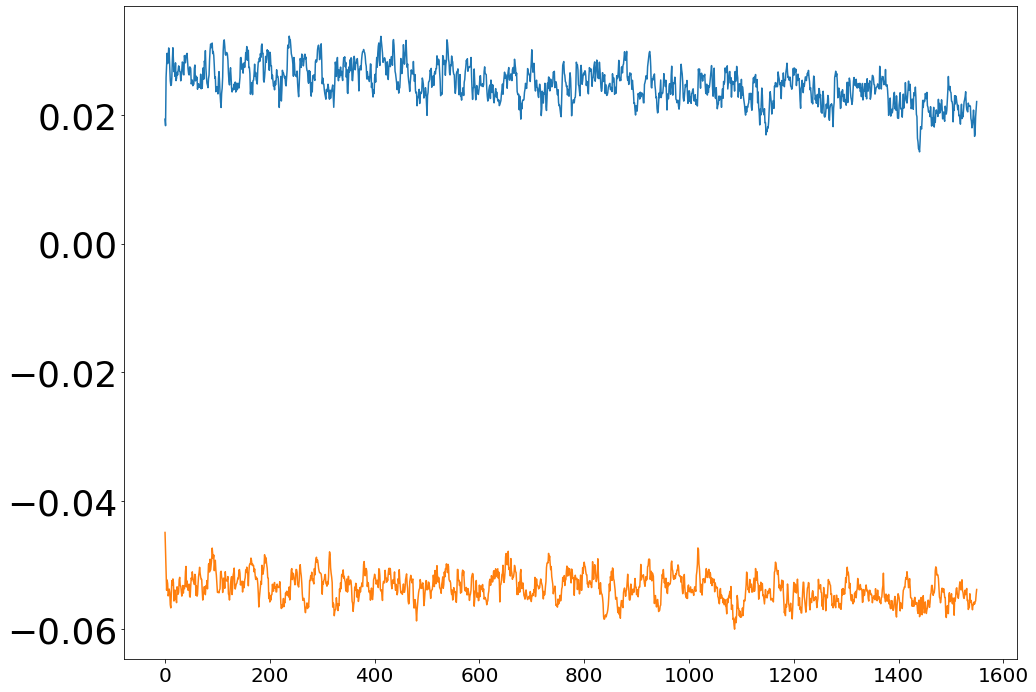

In [89]:
q0= quickAnalyzeDataFrame(df0)

In [90]:
# no gap measurements
folder = r'/data/new_trap/20210823/Bead2/Neutrality/200V_X_SPINYZ_39p5kHz_75V_no_gap_20210825/'
           
df1,v1 = compare_millicharge_full_analysis_perFile(folder,fileNo=1100,gap=0,ElectrodeRatio=0.74,scaleFactor=scaleX)



  0%|          | 0/1100 [00:00<?, ?it/s]

  3%|▎         | 32/1100 [00:01<00:46, 23.14it/s]

  6%|▌         | 64/1100 [00:01<00:33, 30.52it/s]

  9%|▊         | 96/1100 [00:02<00:34, 29.01it/s]

 12%|█▏        | 128/1100 [00:03<00:27, 34.94it/s]

 12%|█▏        | 133/1100 [00:03<00:27, 34.60it/s]

 13%|█▎        | 138/1100 [00:03<00:28, 33.28it/s]

 13%|█▎        | 142/1100 [00:03<00:28, 34.21it/s]

 15%|█▍        | 160/1100 [00:04<00:23, 39.61it/s]

 17%|█▋        | 192/1100 [00:04<00:19, 46.66it/s]

 20%|██        | 224/1100 [00:04<00:16, 53.91it/s]

 23%|██▎       | 256/1100 [00:05<00:12, 67.10it/s]

 26%|██▌       | 288/1100 [00:05<00:11, 67.72it/s]

 29%|██▉       | 320/1100 [00:05<00:10, 73.59it/s]

 32%|███▏      | 352/1100 [00:06<00:09, 78.77it/s]

 35%|███▍      | 384/1100 [00:06<00:08, 83.82it/s]

 38%|███▊      | 416/1100 [00:06<00:07, 85.84it/s]

 41%|████      | 448/1100 [00:07<00:07, 92.84it/s]

 44%|████▎     | 480/1100 [00:07<00:06, 91.11it/s]

 47%|████▋     | 512/11

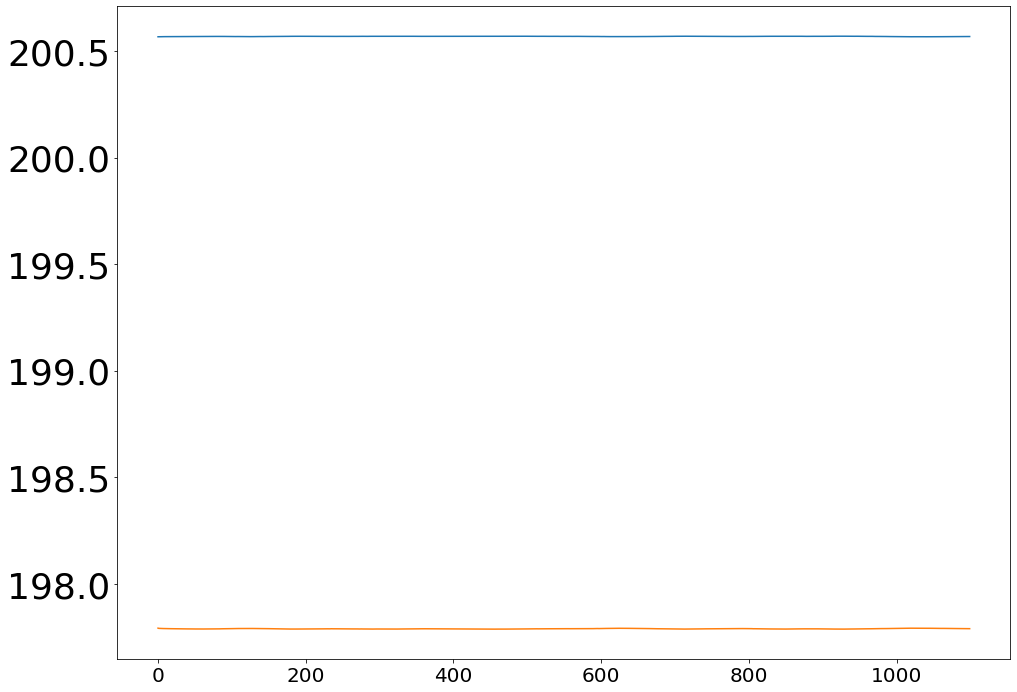

In [91]:
plt.plot(v1[0])
plt.plot(v1[1])
plt.show()

In [95]:
meanDF1 = np.mean(df1)
stdDF1= np.std(df1)/np.sqrt(len(df1))


In [96]:
print(meanDF1)

F1    0.124421
G1    2.209806
dtype: float64


In [97]:
print(stdDF1)

F1    0.014299
G1    0.013552
dtype: float64


In [98]:
np.divide(meanDF1,stdDF1)

F1      8.701311
G1    163.067139
dtype: float64

In [99]:
# no gap measurements
folder = r'/data/new_trap/20210823/Bead2/Neutrality/100V_X_SPINYZ_39p5kHz_75V_no_gap_20210825/'
           
df2,v2 = compare_millicharge_full_analysis_perFile(folder,fileNo=350,gap=0,ElectrodeRatio=0.74,scaleFactor=scaleX)



  0%|          | 0/350 [00:00<?, ?it/s]

 18%|█▊        | 64/350 [00:00<00:00, 421.10it/s]

 37%|███▋      | 128/350 [00:00<00:00, 312.79it/s]

 55%|█████▍    | 192/350 [00:00<00:00, 282.79it/s]

 73%|███████▎  | 256/350 [00:01<00:00, 181.47it/s]

 91%|█████████▏| 320/350 [00:01<00:00, 162.96it/s]

100%|██████████| 350/350 [00:01<00:00, 184.83it/s]

In [101]:
meanDF2 = np.mean(df2)
stdDF2= np.std(df2)/np.sqrt(len(df2))


In [104]:
meanDF2

F1    -3.122962
G1    17.179597
dtype: float64

In [105]:
stdDF2

F1    0.616000
G1    0.553254
dtype: float64

In [106]:
np.divide(meanDF2,stdDF2)

F1    -5.069741
G1    31.051893
dtype: float64

In [109]:
folder = r'/data/new_trap/20210823/Bead2/Neutrality/100V_X_SPINYZ_39p5kHZ_75V_20210825/'
           
df3,v3 = compare_millicharge_full_analysis_perFile(folder,fileNo=860,gap=2,ElectrodeRatio=0.74,scaleFactor=scaleX)




  0%|          | 0/860 [00:00<?, ?it/s]


  4%|▎         | 32/860 [00:01<00:33, 24.56it/s]


  7%|▋         | 64/860 [00:02<00:29, 26.82it/s]


 11%|█         | 96/860 [00:03<00:25, 30.07it/s]


 15%|█▍        | 128/860 [00:03<00:19, 38.47it/s]


 19%|█▊        | 160/860 [00:04<00:18, 37.42it/s]


 22%|██▏       | 192/860 [00:04<00:14, 47.23it/s]


 26%|██▌       | 224/860 [00:05<00:12, 49.77it/s]


 30%|██▉       | 256/860 [00:05<00:10, 59.44it/s]


 33%|███▎      | 288/860 [00:05<00:07, 73.63it/s]


 37%|███▋      | 320/860 [00:06<00:07, 68.42it/s]


 41%|████      | 352/860 [00:06<00:06, 80.98it/s]


 45%|████▍     | 384/860 [00:06<00:06, 73.28it/s]


 48%|████▊     | 416/860 [00:07<00:06, 66.00it/s]


 52%|█████▏    | 448/860 [00:07<00:05, 76.03it/s]


 56%|█████▌    | 480/860 [00:08<00:05, 66.35it/s]


 60%|█████▉    | 512/860 [00:08<00:04, 74.59it/s]


 63%|██████▎   | 544/860 [00:09<00:04, 68.75it/s]


 67%|██████▋   | 576/860 [00:09<00:04, 68.55it/s]


 71%|███████   | 608/8

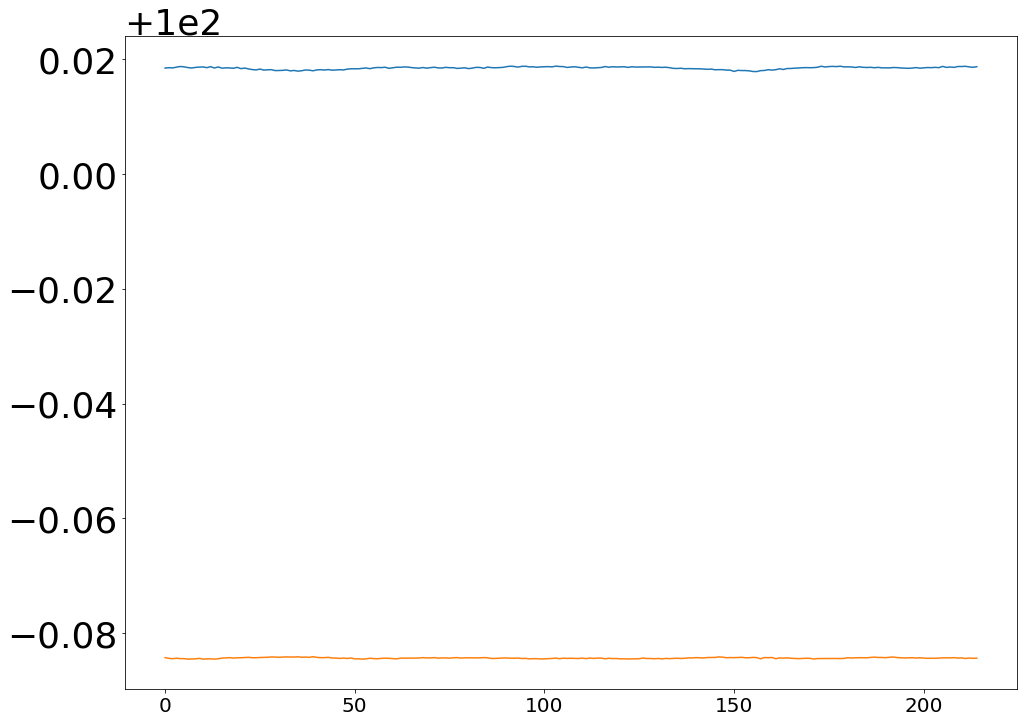

In [110]:
plt.plot(v3[0][::4])
plt.plot(v3[1][2::4])
plt.show()

In [111]:
df3

,F1,F2,F3,G1,G2,G3,A,A/Um,B
0,0.023345,-0.046071,193.537413,-0.033634,0.036888,-404.223616,-0.010747,-1.720672e-06,0.020960
1,0.019284,-0.023555,-23.545927,-0.043631,0.054912,65.831567,0.001853,2.966025e-07,0.037638
2,0.017929,-0.006898,61.835263,-0.020211,0.046857,-188.408374,0.012825,2.053352e-06,0.049138
3,0.023564,-0.014066,-59.883634,-0.033400,0.017555,-87.724332,0.013155,2.106297e-06,-0.007418
4,0.008898,-0.038721,-56.410337,-0.029563,0.045057,234.468646,-0.019756,-3.163029e-06,0.037121
...,...,...,...,...,...,...,...,...,...
210,0.017715,-0.021418,66.116902,-0.004998,0.060070,-97.752743,0.001866,2.987444e-07,0.083907
211,0.037271,-0.011242,-90.033934,-0.039520,0.039856,69.572138,0.028952,4.635509e-06,0.019467
212,0.024177,-0.013558,149.495474,-0.016141,0.046040,-118.701696,0.014144,2.264623e-06,0.051999
213,0.021677,-0.046075,-291.817270,-0.042608,0.057365,108.416910,-0.012418,-1.988246e-06,0.042293


F1      2.096433e-02
F2     -2.318087e-02
F3     -1.533853e+01
G1     -2.799401e-02
G2      5.040360e-02
G3     -6.196289e+00
A       3.810482e-03
A/Um    6.100904e-07
B       4.660331e-02
dtype: float64
F1      7.758128e-04
F2      9.333350e-04
F3      9.973647e+00
G1      7.965974e-04
G2      8.058135e-04
G3      9.664394e+00
A       1.039105e-03
A/Um    1.663695e-07
B       1.424587e-03
dtype: float64
F1      27.022403
F2     -24.836604
F3      -1.537906
G1     -35.141984
G2      62.549953
G3      -0.641146
A        3.667081
A/Um     3.667081
B       32.713564
dtype: float64


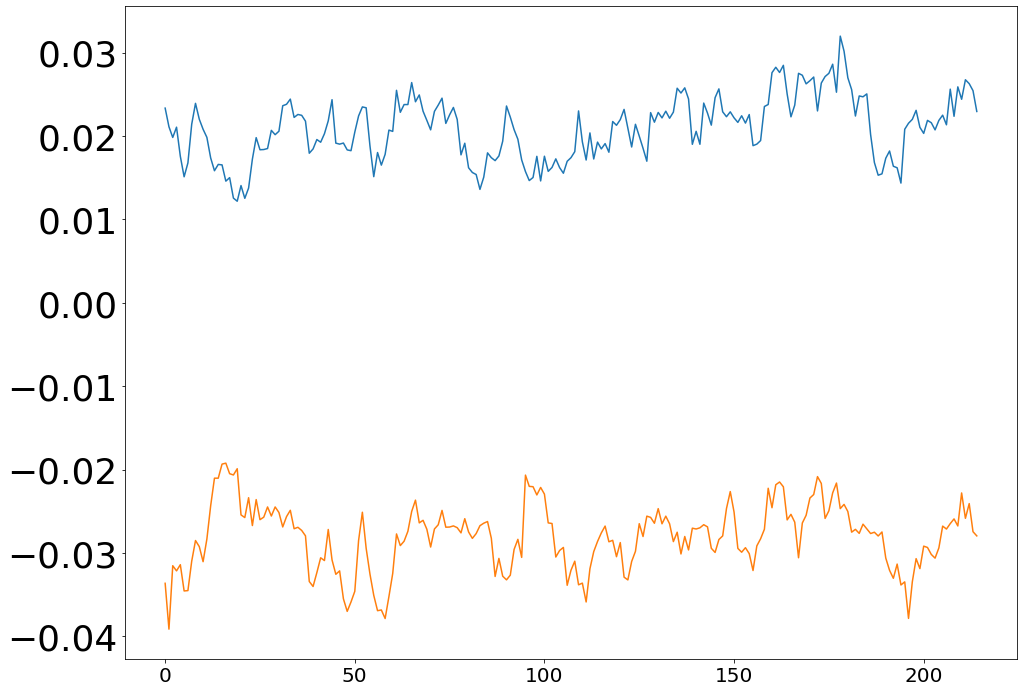

In [112]:
q3= quickAnalyzeDataFrame(df3)

In [113]:
folder = r'/data/new_trap/20210823/Bead2/Neutrality/20V_X_SPINYZ_39p75kHz_75V_alternate_no_gap_20210825/'
df4,v4 = compare_millicharge_full_analysis_perFile(folder,fileNo=3900,gap=1,ElectrodeRatio=0.74,scaleFactor=scaleX)





  0%|          | 0/3900 [00:00<?, ?it/s]


  2%|▏         | 64/3900 [00:00<00:20, 190.35it/s]


  2%|▏         | 96/3900 [00:01<00:50, 74.81it/s] 


  3%|▎         | 128/3900 [00:01<00:45, 83.71it/s]


  4%|▍         | 160/3900 [00:01<00:39, 93.64it/s]


  5%|▍         | 192/3900 [00:02<00:45, 81.80it/s]


  6%|▌         | 224/3900 [00:02<00:39, 93.49it/s]


  7%|▋         | 256/3900 [00:02<00:36, 100.56it/s]


  7%|▋         | 288/3900 [00:03<00:42, 84.19it/s] 


  8%|▊         | 320/3900 [00:04<00:50, 71.33it/s]


  9%|▉         | 352/3900 [00:04<00:41, 85.87it/s]


 10%|▉         | 384/3900 [00:04<00:47, 73.49it/s]


 11%|█         | 416/3900 [00:04<00:37, 92.21it/s]


 11%|█▏        | 448/3900 [00:05<00:35, 97.27it/s]


 12%|█▏        | 480/3900 [00:05<00:35, 96.64it/s]


 13%|█▎        | 512/3900 [00:05<00:32, 105.65it/s]


 14%|█▍        | 544/3900 [00:06<00:30, 108.98it/s]


 15%|█▍        | 576/3900 [00:06<00:31, 106.05it/s]


 16%|█▌        | 608/3900 [00:06<00:36, 89.60it/

In [114]:
df4

,F1,F2,F3,G1,G2,G3,A,A/Um,B
0,0.068386,-0.009553,-0.009553,-0.050865,-0.015886,-0.015886,0.061317,0.000025,-0.074377
1,0.095814,0.027669,0.027669,0.083393,0.074516,0.074516,0.116289,0.000047,0.193676
2,-0.068571,-0.011397,-0.011397,0.015123,-0.013909,-0.013909,-0.077005,-0.000031,-0.005461
3,0.003397,-0.030429,-0.030429,-0.021574,0.022590,0.022590,-0.019120,-0.000008,0.011860
4,0.115320,0.029460,0.029460,-0.017862,0.132646,0.132646,0.137121,0.000055,0.178454
...,...,...,...,...,...,...,...,...,...
1945,0.188858,0.008116,0.008116,-0.134495,-0.088651,-0.088651,0.194863,0.000078,-0.265699
1946,0.054802,-0.110423,-0.110423,0.045100,0.040865,0.040865,-0.026911,-0.000011,0.105580
1947,-0.064324,-0.091851,-0.091851,0.019333,-0.004324,-0.004324,-0.132294,-0.000053,0.012934
1948,0.036783,0.007423,0.007423,-0.037454,0.074231,0.074231,0.042276,0.000017,0.072408


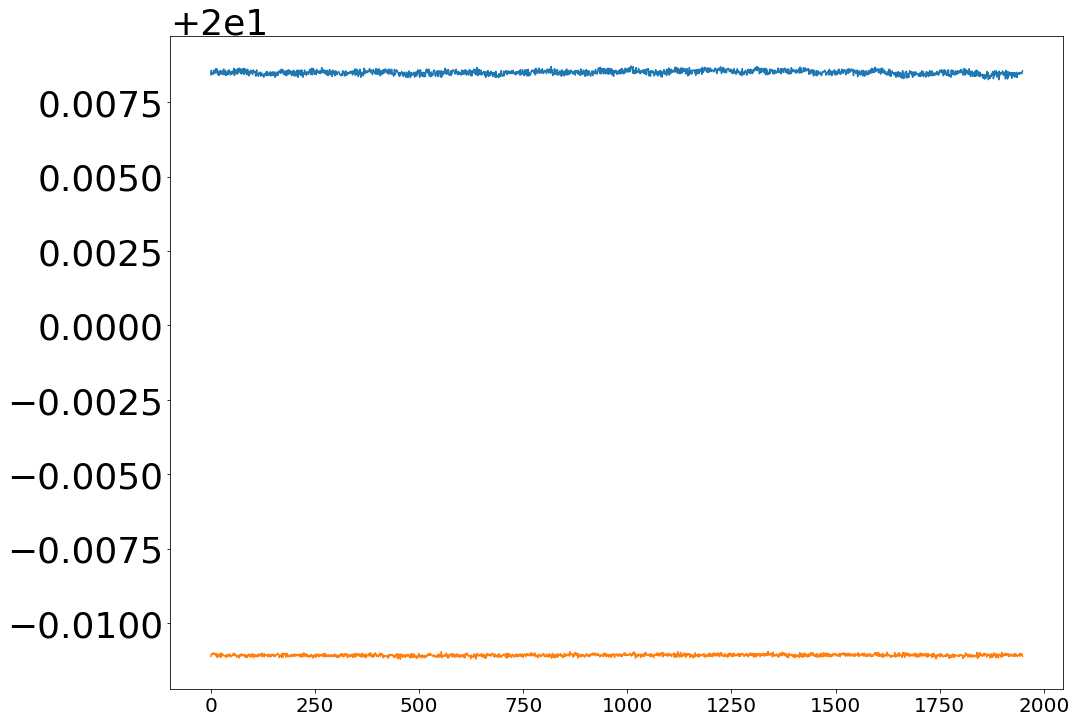

In [115]:
plt.plot(v4[0][0::2])
plt.plot(v4[1][1::2])
#plt.xlim(0,5)
plt.show()

F1      0.021388
F2     -0.022058
F3     -0.022058
G1     -0.004822
G2      0.008372
G3      0.008372
A       0.005064
A/Um    0.000002
B       0.007568
dtype: float64
F1      1.384898e-03
F2      1.373815e-03
F3      1.373815e-03
G1      1.295349e-03
G2      1.309772e-03
G3      1.309772e-03
A       1.727415e-03
A/Um    6.924887e-07
B       2.321846e-03
dtype: float64
F1      15.443531
F2     -16.056333
F3     -16.056333
G1      -3.722764
G2       6.391937
G3       6.391937
A        2.931828
A/Um     2.931828
B        3.259584
dtype: float64


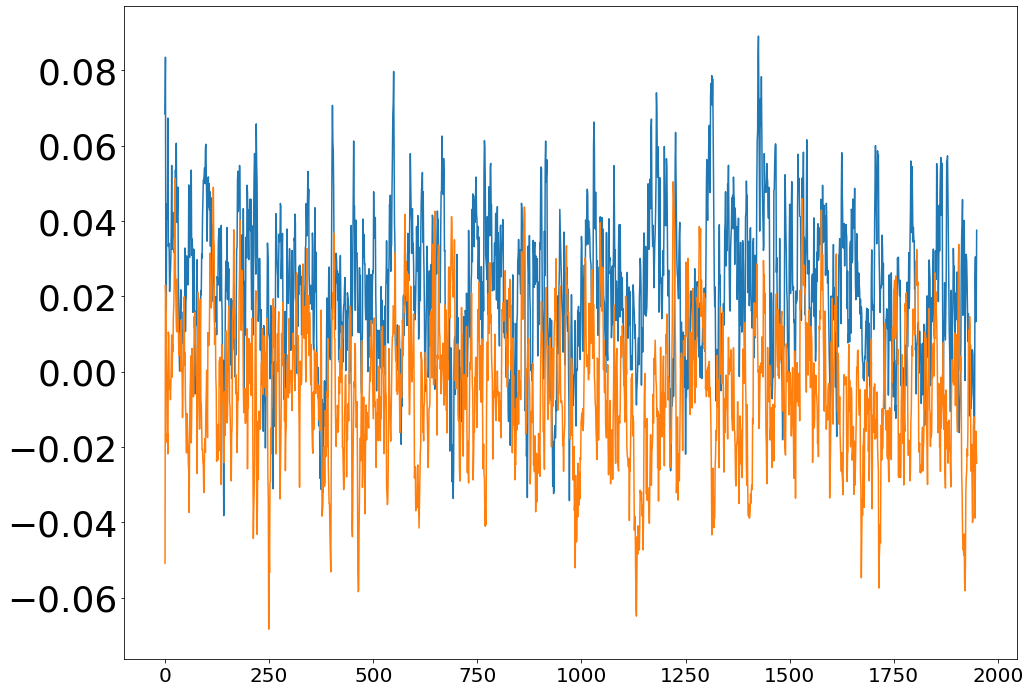

In [116]:
q4= quickAnalyzeDataFrame(df4)

In [118]:
folder = r'/data/new_trap/20210823/Bead2/Neutrality/20V_X_SPINYZ_39p75kHz_75V_no_gap_20210826/'
df5,v5 = compare_millicharge_full_analysis_perFile(folder,fileNo=1000,gap=0,ElectrodeRatio=0.74,scaleFactor=scaleX)




  0%|          | 0/1000 [00:00<?, ?it/s]


  6%|▋         | 64/1000 [00:00<00:02, 358.44it/s]


 13%|█▎        | 128/1000 [00:00<00:03, 225.35it/s]


 19%|█▉        | 192/1000 [00:01<00:04, 198.98it/s]


 26%|██▌       | 256/1000 [00:01<00:04, 177.10it/s]


 32%|███▏      | 320/1000 [00:02<00:04, 155.01it/s]


 38%|███▊      | 384/1000 [00:02<00:04, 146.46it/s]


 45%|████▍     | 448/1000 [00:03<00:04, 116.37it/s]


 51%|█████     | 512/1000 [00:04<00:04, 113.48it/s]


 58%|█████▊    | 576/1000 [00:04<00:03, 118.13it/s]


 64%|██████▍   | 640/1000 [00:05<00:03, 101.44it/s]


 70%|███████   | 704/1000 [00:05<00:02, 103.95it/s]


 77%|███████▋  | 768/1000 [00:06<00:02, 107.56it/s]


 83%|████████▎ | 832/1000 [00:06<00:01, 112.76it/s]


 90%|████████▉ | 896/1000 [00:07<00:00, 116.85it/s]


 96%|█████████▌| 960/1000 [00:08<00:00, 117.63it/s]


100%|██████████| 1000/1000 [00:08<00:00, 124.80it/s]

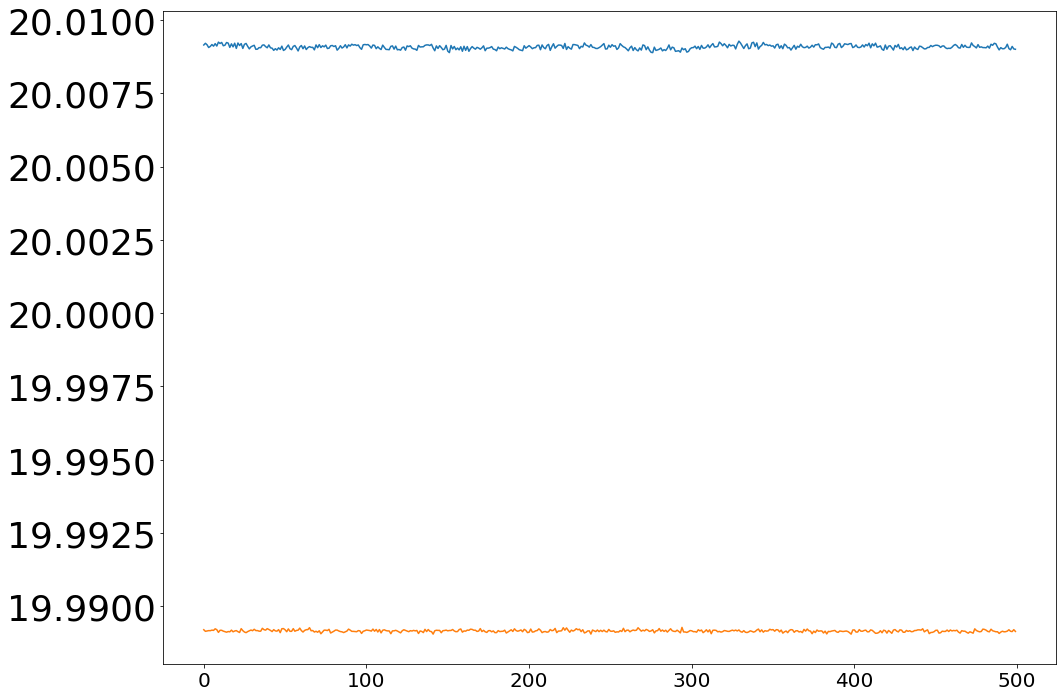

In [119]:
plt.plot(v5[0][::2])
plt.plot(v5[1][1::2])
plt.show()

In [120]:
meanDF5 = np.mean(df5)
stdDF5= np.std(df5)/np.sqrt(len(df5))


In [121]:
print(meanDF5)

F1   -0.649303
G1    2.488090
dtype: float64


In [122]:
print(stdDF5)

F1    1.794510
G1    1.718778
dtype: float64
